In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten,LeakyReLU, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"; # 1번째 gpu를 사용하고 싶다면, 
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [3]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows,img_cols,channels)
z_dim =100

In [4]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256*7*7, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    
    model.add(Conv2DTranspose(128,kernel_size=3, strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, kernel_size=3,strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1,kernel_size=3,strides=2,padding='same'))
    model.add(Activation('tanh'))
    
    return model

In [5]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(32,kernel_size=(3,3),strides=2,input_shape=img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64,kernel_size=(3,3),strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(128,kernel_size=(3,3),strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    return model

In [7]:
def build_gan(generator, discriminator):
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

generator = build_generator(z_dim)
discriminator.trainable=False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer = Adam())

In [8]:
def sample_images(generator, image_grid_rows=4,image_grid_columns=4):
    z = np.random.normal(0,1,(image_grid_rows * image_grid_columns,z_dim))
    
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig,axs = plt.subplots(image_grid_rows,image_grid_columns,figsize=(4,4),sharey=True,sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt+=1

In [11]:
losses = []
accuracies = []
iteration_check_points = []

def train(iterations, batch_size, sample_interval):
    (x_train,_),(_,_) = mnist.load_data()
    
    x_train = x_train / 127.5 - 1.0
    x_train = np.expand_dims(x_train,axis=3)
    
    real = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0,x_train.shape[0],batch_size)
        imgs = x_train[idx]
        
        z=np.random.normal(0,1,(batch_size,100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs,real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs,fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real,d_loss_fake)
        
        g_loss = gan.train_on_batch(z,real)
        
        if(iteration+1) % sample_interval == 0:
            losses.append((d_loss,g_loss))
            accuracies.append(100.0*accuracy)
            iteration_check_points.append(iteration+1)
            print(f"{iteration+1} [D 손실: {d_loss:f}, 정확도: {100.0*accuracy}][G 손실: {g_loss}]")
            sample_images(generator)

1000 [D 손실: 0.301588, 정확도: 86.328125][G 손실: 2.917440414428711]
2000 [D 손실: 0.328660, 정확도: 85.15625][G 손실: 2.3723063468933105]
3000 [D 손실: 0.434793, 정확도: 77.34375][G 손실: 1.6963403224945068]
4000 [D 손실: 0.460348, 정확도: 80.859375][G 손실: 1.8994423151016235]
5000 [D 손실: 0.389501, 정확도: 83.59375][G 손실: 2.0500283241271973]
6000 [D 손실: 0.293077, 정확도: 87.109375][G 손실: 2.2872581481933594]
7000 [D 손실: 0.333392, 정확도: 84.375][G 손실: 2.1595218181610107]
8000 [D 손실: 0.395431, 정확도: 82.421875][G 손실: 2.1844325065612793]
9000 [D 손실: 0.369623, 정확도: 83.203125][G 손실: 1.963325023651123]
10000 [D 손실: 0.347397, 정확도: 83.984375][G 손실: 1.936649203300476]
11000 [D 손실: 0.432018, 정확도: 80.859375][G 손실: 1.9315682649612427]
12000 [D 손실: 0.456627, 정확도: 81.25][G 손실: 2.0702860355377197]
13000 [D 손실: 0.344507, 정확도: 87.890625][G 손실: 1.9509477615356445]
14000 [D 손실: 0.342649, 정확도: 82.03125][G 손실: 2.027384042739868]
15000 [D 손실: 0.333355, 정확도: 85.546875][G 손실: 2.2054903507232666]
16000 [D 손실: 0.414468, 정확도: 82.421875][G 손실: 2.21

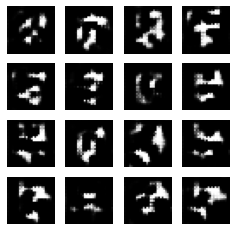

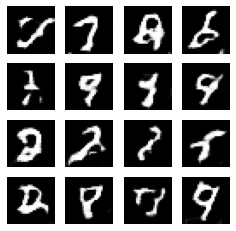

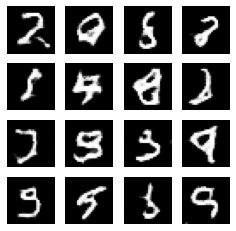

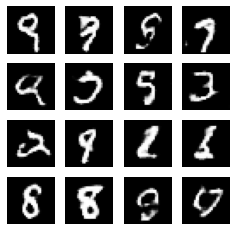

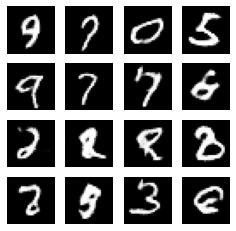

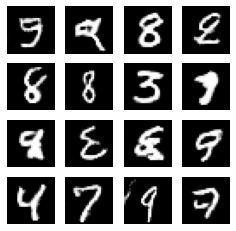

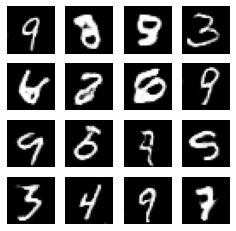

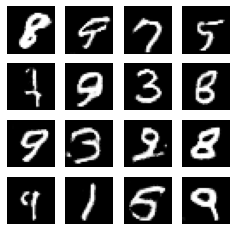

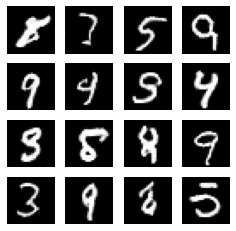

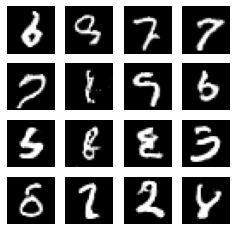

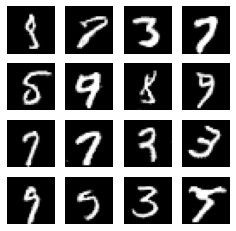

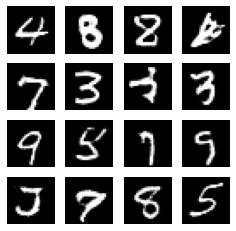

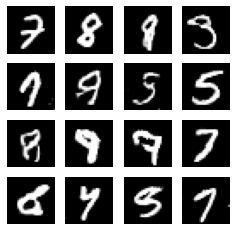

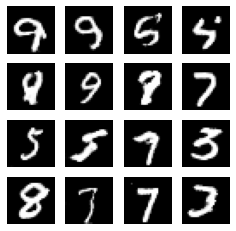

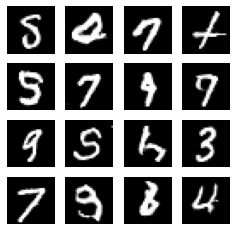

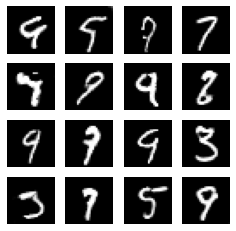

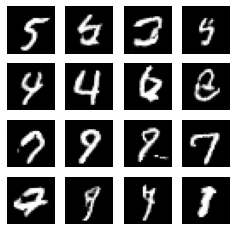

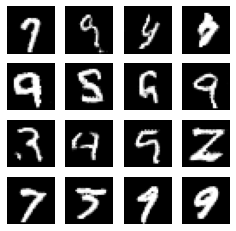

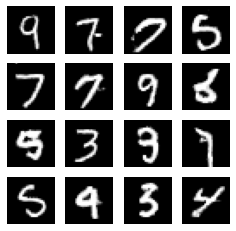

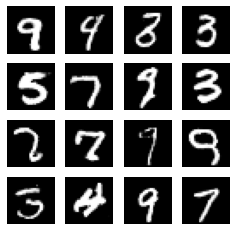

In [12]:
iterations = 20000
batch_size = 128
sample_interval = 1000


train(iterations,batch_size,sample_interval)